In [28]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import sys
import copy
import os
import glob
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import pickle
import time
#from util import *
#from ops import *
import multiprocessing
from multiprocessing import Pool
#from model import DCGAN
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#np.set_printoptions(threshold='nan')

In [36]:
from sklearn.preprocessing import StandardScaler

In [2]:
#Setting up the dataset for ML
# Text file data converted to integer data type
x_data = np.loadtxt("dataset/x_dataTrain.txt", dtype=float)
print(x_data)

[[3.27030e-24 3.07616e-24 5.22539e-24 ... 1.32958e-21 1.33228e-21
  1.35562e-21]
 [1.30267e-20 1.30677e-20 1.31157e-20 ... 3.81686e-20 3.81212e-20
  3.80739e-20]
 [6.26322e-21 6.28294e-21 6.30602e-21 ... 1.83835e-20 1.83606e-20
  1.83378e-20]
 ...
 [2.18046e-21 2.18672e-21 2.19415e-21 ... 4.09628e-21 4.09113e-21
  4.08599e-21]
 [8.45625e-21 8.48075e-21 8.50976e-21 ... 1.65705e-20 1.65496e-20
  1.65289e-20]
 [9.18122e-27 9.43401e-27 1.16085e-26 ... 4.02891e-22 4.05835e-22
  4.14389e-22]]


In [3]:
#Setting up the dataset for ML
# Text file data converted to integer data type
y_data = np.loadtxt("dataset/y_dataTrain.txt", dtype=float)
print(y_data)

[[5.44779525e-02 3.63563344e-01 3.93226327e-01 ... 3.84039400e-03
  1.04632279e-03 8.05759487e-06]
 [4.16023007e-02 1.98831946e-01 3.19697149e-01 ... 1.58676888e-04
  2.70865681e-04 6.98852685e-06]
 [3.25809662e-02 3.30184164e-01 2.25277622e-01 ... 3.64259914e-04
  1.77938880e-05 5.15590766e-06]
 ...
 [6.00137545e-03 2.25446819e-01 2.36290974e-01 ... 3.41272939e-03
  1.68012889e-04 8.55777941e-06]
 [9.61424398e-03 2.41019755e-01 4.74460251e-01 ... 2.28148605e-03
  1.53862644e-04 3.59720563e-06]
 [1.48247666e-02 4.65782909e-01 3.00848722e-01 ... 5.70894991e-03
  1.74632155e-04 1.76412088e-06]]


In [15]:
feature_dict = {
    0 : 'H2O',
    1 : 'CO2',
    2 : 'O2',
    3 : 'N2',
    4 : 'CH4',
    5 : 'N2O',
    6 : 'CO',
    7 : 'O3',
    8 : 'SO2',
    9 : 'NH3',
    10 : 'C2H6',
    11 : 'NO2'
}

In [4]:
features = pd.DataFrame(x_data)
labels = pd.DataFrame(y_data)

In [16]:
labels.rename(columns=feature_dict,
          inplace=True)

In [18]:
labels

,H2O,CO2,O2,N2,CH4,N2O,CO,O3,SO2,NH3,C2H6,NO2
0,0.054478,0.363563,0.393226,0.023477,0.128073,0.003160,0.020260,0.000787,0.008082,0.003840,0.001046,0.000008
1,0.041602,0.198832,0.319697,0.372766,0.045681,0.005339,0.007645,0.002416,0.005585,0.000159,0.000271,0.000007
2,0.032581,0.330184,0.225278,0.367305,0.029888,0.009178,0.000921,0.002042,0.002236,0.000364,0.000018,0.000005
3,0.047566,0.229283,0.522326,0.004332,0.143489,0.002901,0.019156,0.001016,0.022003,0.007825,0.000087,0.000016
4,0.083559,0.197881,0.398276,0.222883,0.063702,0.004544,0.016299,0.003417,0.006714,0.002307,0.000413,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...
9998,0.032119,0.347432,0.359901,0.227611,0.015221,0.004894,0.006354,0.002510,0.002605,0.001277,0.000074,0.000002
9999,0.010497,0.180198,0.331853,0.423897,0.034217,0.006691,0.008135,0.000428,0.003644,0.000265,0.000172,0.000002
10000,0.006001,0.225447,0.236291,0.465001,0.050457,0.000116,0.006873,0.000623,0.005600,0.003413,0.000168,0.000009
10001,0.009614,0.241020,0.474460,0.198173,0.049041,0.007941,0.003215,0.004247,0.009849,0.002281,0.000154,0.000004


In [20]:
#Splitting dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [40]:
scaler = StandardScaler()
X_scaledTrain = scaler.fit_transform(X_train)
X_scaledTest = scaler.fit_transform(X_test)

In [41]:
y_scaler = StandardScaler()
y_scaledTrain = scaler.fit_transform(y_train)
y_scaledTest = scaler.fit_transform(y_test)

# Testing Neural Network Regression Model

In [39]:
#Creating Neural Network model
exoAtmos = Sequential()

exoAtmos.add(Dense(128, kernel_initializer='normal',input_dim = X_scaledTrain.shape[1], activation='relu'))

# The Hidden Layers :
exoAtmos.add(Dense(256, kernel_initializer='normal',activation='relu'))
exoAtmos.add(Dense(256, kernel_initializer='normal',activation='relu'))
exoAtmos.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
exoAtmos.add(Dense(1, kernel_initializer='normal',activation='softmax'))

# Compile the network :
exoAtmos.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
exoAtmos.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               560512    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 725,377
Trainable params: 725,377
Non-trainable params: 0
_________________________________________________________________


In [65]:
#Training the model
history = exoAtmos.fit(X_scaledTrain, y_scaledTrain, epochs=450, batch_size=32, validation_split = 0.2)

Epoch 1/450
168/168 [==============================] - 2s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 2/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 3/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 4/450
168/168 [==============================] - 1s 7ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 5/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 6/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 7/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 8/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 9/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 10/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_lo

Epoch 81/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 82/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 83/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 84/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 85/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 86/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 87/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 88/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 89/450
168/168 [==============================] - 1s 7ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 90/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971

168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 161/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 162/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 163/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 164/450
168/168 [==============================] - ETA: 0s - loss: 1.999 - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 165/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 166/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 167/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 168/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 169/450
168/168 [==============================] - 1s 8ms

168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 240/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 241/450
168/168 [==============================] - 1s 7ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 242/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 243/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 244/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 245/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 246/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 247/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 248/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - v

168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 319/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 320/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 321/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 322/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 323/450
168/168 [==============================] - 2s 9ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 324/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 325/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 326/450
168/168 [==============================] - 1s 8ms/step - loss: 1.9971 - val_loss: 2.0117
Epoch 327/450
168/168 [==============================] - 1s 9ms/step - loss: 1.9971 - v

KeyboardInterrupt: 

In [66]:
exoAtmos.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
test_loss = exoAtmos.evaluate(X_scaledTrain, y_scaledTrain)

210/210 [==============================] - 1s 3ms/step - loss: 2.0000


In [68]:
test_loss

2.0000009536743164

dict_keys(['loss', 'val_loss'])


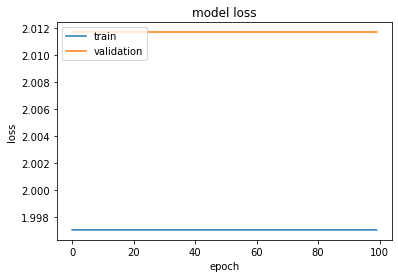

In [69]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Testing xGBoost Regressor